In [1]:
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt

## Loading and preparing data

In [2]:
imdb_dir = '/home/karolkul/Downloads/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [3]:
labels = []
texts = []

In [4]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [5]:
# shortens reviews to 100 words
maxlen = 100
# training on 7000 samples
training_samples = 7000
# validation on 25 000 samples
validation_samples = 25000
# only first 10 000 words
max_words = 10000

In [6]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' %len(word_index))

Found 88582 unique tokens.


In [8]:
data = pad_sequences(sequences, maxlen=maxlen)

In [9]:
labels = np.asarray(labels)
print('Shape of data tensor: ', data.shape)
print('Shape of tensor labels: ', labels.shape)

Shape of data tensor:  (25000, 100)
Shape of tensor labels:  (25000,)


In [10]:
# splitting data to train and validation sets but before shuffle 
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [11]:
glove_dir = '/home/karolkul/Downloads/glove'

In [12]:
# parsing glove file
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove_100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s vectors of words.' % len(embeddings_index))

Found 400000 vectors of words.


In [13]:
# preparing glove embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # words which not found will be replace by 0
            embedding_matrix[i] = embedding_vector

## The model

In [14]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,321,121
Trainable params: 1,321,121
Non-trainable params: 0
______________________________________________

In [15]:
# loading before trained embeeding words into Embedding layer
model.layers[0].set_weights([embedding_matrix])
# frozing Embedding layer by False arg
model.layers[0].trainable = False

In [16]:
# compile and train model
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=25,
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h')

Epoch 1/25
219/219 [==============================] - 1s 7ms/step - loss: 0.7216 - acc: 0.5037 - val_loss: 0.6907 - val_acc: 0.5614
Epoch 2/25
219/219 [==============================] - 1s 6ms/step - loss: 0.6808 - acc: 0.5674 - val_loss: 0.6469 - val_acc: 0.6492
Epoch 3/25
219/219 [==============================] - 1s 6ms/step - loss: 0.6397 - acc: 0.6259 - val_loss: 0.6416 - val_acc: 0.6263
Epoch 4/25
219/219 [==============================] - 1s 6ms/step - loss: 0.6060 - acc: 0.6566 - val_loss: 0.6028 - val_acc: 0.6779
Epoch 5/25
219/219 [==============================] - 1s 6ms/step - loss: 0.5704 - acc: 0.6787 - val_loss: 0.6338 - val_acc: 0.6452
Epoch 6/25
219/219 [==============================] - 1s 6ms/step - loss: 0.5378 - acc: 0.7017 - val_loss: 0.5970 - val_acc: 0.6787
Epoch 7/25
219/219 [==============================] - 1s 6ms/step - loss: 0.5075 - acc: 0.7214 - val_loss: 0.6098 - val_acc: 0.6865
Epoch 8/25
219/219 [==============================] - 1s 6ms/step - loss: 0.

## Results

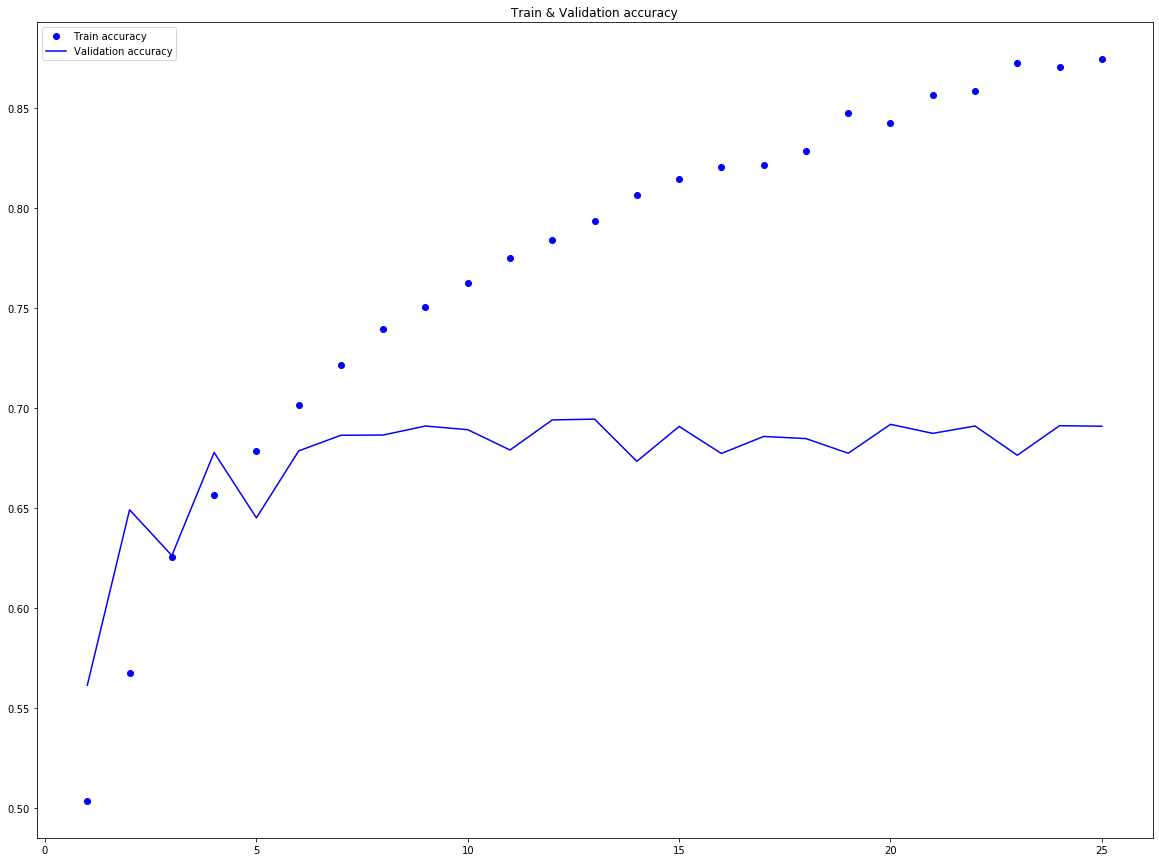

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 15))
plt.plot(epochs, acc, 'bo', label='Train accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Train & Validation accuracy')
plt.legend()

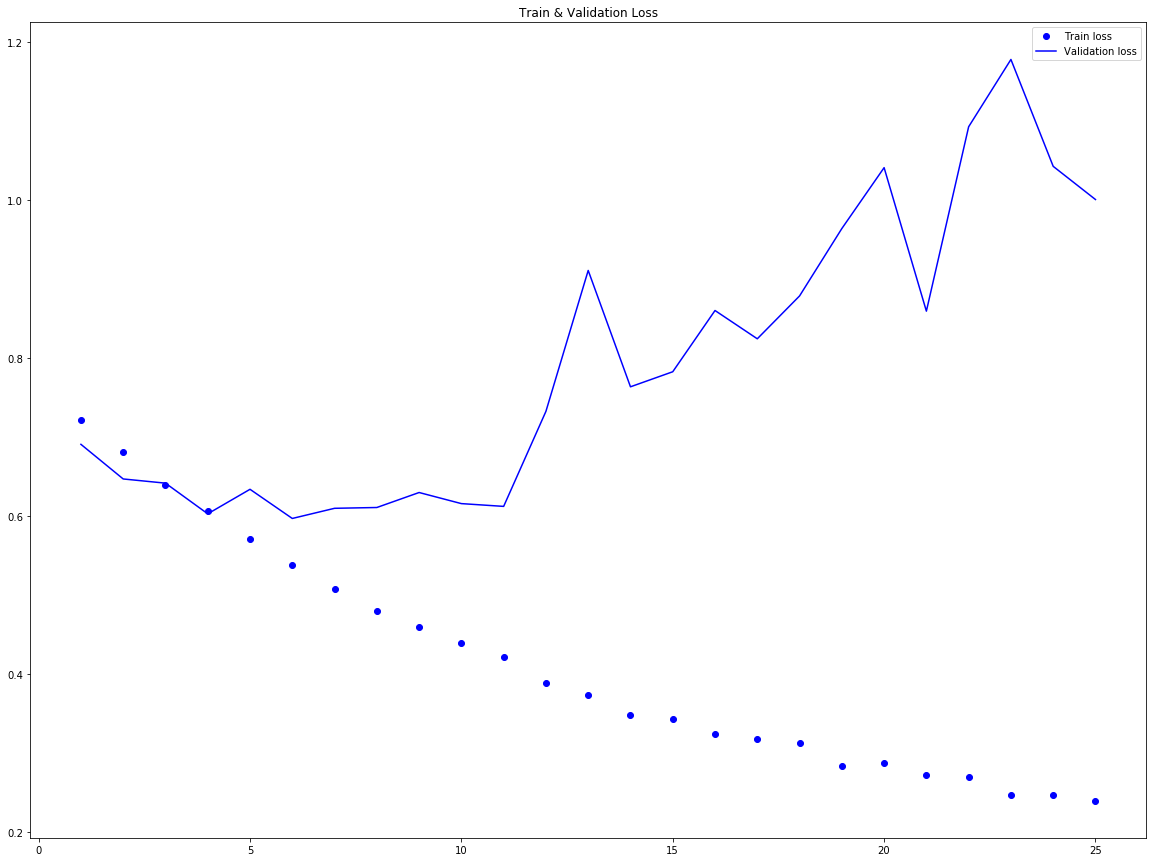

In [18]:
plt.figure(figsize=(20, 15))
plt.plot(epochs, loss, 'bo', label='Train loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Train & Validation Loss')
plt.legend()

## Overfitting after 13 epoch.

In [19]:
# switching test data into tokens
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [20]:
model.load_weights('pre_trained_glove_model.h')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 1ms/step - loss: 0.9954 - acc: 0.6891


[0.9954110383987427, 0.6891199946403503]

## Final score is 69% on 7k samples but model is overfitting after 9 epoch, i used dropout layer to minimalizing overfitting.
At first attempt i used 200 samples and reach score 56%.
